# Import Libraries and load dataset

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import functools
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import itertools
import logging
import time
from scipy.special import digamma
from scipy.optimize import linear_sum_assignment
from tqdm.auto import tqdm
from scipy.spatial import Voronoi
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import pickle
from scipy.special import gammaln, digamma, polygamma
import scipy.sparse
import scipy.sparse.linalg
np.float = float  
import pickle 
import os


In [2]:
h5ad_path = r'C:\Users\bkrnd\OneDrive\Documents\Desktop\DebarpitaDash_220328_SpatialLDA\Dataset2_osmFISH.h5ad'
adata = sc.read_h5ad(h5ad_path)

# Clustering using Leiden

In [ ]:
adata.obs['n_counts'] = adata.X.sum(axis=1) 
adata.obs['log_counts'] = np.log1p(adata.obs['n_counts']) 
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1) 
# sc.pp.filter_cells(adata, min_genes=100)  # Commented out filtering out cells
# sc.pp.filter_genes(adata, min_cells=3)    # Commented out filtering out genes
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(axis=1) / adata.obs['n_counts']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=-1, resolution=0.75)
print(adata.n_vars)  # Number of genes remaining
print(adata.n_obs)   # Number of cells remaining

# Featurize samples

In [4]:
# how many times a unique cluster appears in a row and returns count
def neighborhood_to_cluster(df, indices):
    clusters = df.iloc[indices].cluster
    return clusters.value_counts()

def neighborhood_to_marker(df, indices, markers):
    neighborhood_genes = df.loc[:, markers].iloc[indices]
    print("Neighborhood gene expressions:\n", neighborhood_genes)
    return (neighborhood_genes > 0).sum()


def neighborhood_to_avg_marker(df, indices, markers):
    return df.loc[:, markers].iloc[indices].mean()
def neighborhood_to_count(df, indices):
    return pd.Series([len(indices)])


In [5]:
# characterize features around anchor cells
def _featurize_cells(df, neighborhood_feature_fn, radius, is_anchor_col,
                     x_col, y_col, z_col=None, include_anchors=False):
    anchor_cells = df[df[is_anchor_col]]
    if include_anchors:
        neighborhood_cells = df
    else:
        neighborhood_cells = df[~df[is_anchor_col]]
    if len(neighborhood_cells.index) == 0:
        raise ValueError("There are no neighbours to compute features from \
(try include_anchors = True)")

    feature_fn = functools.partial(neighborhood_feature_fn, neighborhood_cells)
    coord_cols = [x_col, y_col]
    if z_col is not None:
        coord_cols.append(z_col)
    anchor_kdTree = KDTree(anchor_cells[coord_cols].values)
    neighborhood_kdTree = KDTree(neighborhood_cells[['x', 'y']].values)
    neighborhoods = anchor_kdTree.query_ball_tree(neighborhood_kdTree, radius, p=2.0)
    print("Number of neighborhoods found for each anchor:", [len(n) for n in neighborhoods])

    neighborhood_features = pd.concat(map(feature_fn, neighborhoods), axis=1).T
    neighborhood_features.index = anchor_cells.index
    blank_row_mask = neighborhood_features.isnull().all(axis=1)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=1, label="All Cells")
    ax.scatter(anchor_cells['x'], anchor_cells['y'], color='red', s=5, label="Anchor Cells")
    ax.scatter(neighborhood_cells['x'], neighborhood_cells['y'], color='blue', s=5, label="Neighborhood Cells")
    plt.legend()
    plt.show()


    return neighborhood_features[~blank_row_mask]

In [6]:
def _featurize_sample(data, neighborhood_feature_fn, radius, is_anchor_col,
                      x_col, y_col, z_col=None, include_anchors=False):
    i, df = data
    sample_features = _featurize_cells(df, neighborhood_feature_fn, radius,
                                       is_anchor_col, x_col, y_col, z_col=z_col,
                                       include_anchors=include_anchors)
    sample_features.index = map(lambda x: (i, x), sample_features.index)
    return sample_features


In [7]:
def featurize_samples(sample_dfs, neighborhood_feature_fn, radius, is_anchor_col,
                      x_col, y_col, z_col=None, n_processes=None,
                      include_anchors=False):
    all_sample_features = []
    featurize_sample_fn = functools.partial(
        _featurize_sample, neighborhood_feature_fn=neighborhood_feature_fn, radius=radius,
        is_anchor_col=is_anchor_col, x_col=x_col, y_col=y_col, z_col=z_col,
        include_anchors=include_anchors)
    if n_processes is not None:
        with Pool(n_processes) as pool:
            total = len(sample_dfs)
            all_sample_features = list(tqdm(pool.imap(featurize_sample_fn,
                                                      sample_dfs.items()),
                                            total=total))
    else:
        for i, sample_df in sample_dfs.items():
            sample_features = featurize_sample_fn((i, sample_df))
            all_sample_features.append(sample_features)

    all_sample_features = pd.concat(all_sample_features).fillna(0)
    return all_sample_features

In [8]:
anchor_cluster = [1]
adata.obs['is_anchor'] = adata.obs['leiden'].astype(str).isin([str(c) for c in anchor_cluster])
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [9]:



x_threshold = 10000.0 
sample_df_1 = adata[adata.obs['x'] < x_threshold].to_df()
sample_df_2 = adata[adata.obs['x'] >= x_threshold].to_df()
sample_df_1['is_anchor'] = adata.obs['is_anchor'][adata.obs['x'] < x_threshold].values
sample_df_2['is_anchor'] = adata.obs['is_anchor'][adata.obs['x'] >= x_threshold].values
sample_df_1['x'] = adata.obs['x'][adata.obs['x'] < x_threshold].values
sample_df_1['y'] = adata.obs['y'][adata.obs['x'] < x_threshold].values

sample_df_2['x'] = adata.obs['x'][adata.obs['x'] >= x_threshold].values
sample_df_2['y'] = adata.obs['y'][adata.obs['x'] >= x_threshold].values

sample_dfs = {
    'sample_1': sample_df_1,
    'sample_2': sample_df_2
}



In [10]:
sample_df_1.columns

Index(['Gad2', 'Slc32a1', 'Crhbp', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',
       'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 'Kcnip2', 'Aldoc', 'Gfap', 'Serpinf1',
       'Mfge8', 'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2', 'Ctps',
       'Anln', 'Mrc1', 'Hexb', 'Ttr', 'Foxj1', 'Vtn', 'Flt1', 'Apln', 'Acta2',
       'is_anchor', 'x', 'y'],
      dtype='object')

In [11]:
marker_genes = ['Syt6', 'Cpne5', 'Kcnip2', 'Tbr1', 'Hexb', 'Lamp5', 'Plp1', 'Gad2', 'Tmem2', 'Cnr1', 'Serpinf1', 'Ctps', 'Slc32a1', 'Mrc1', 'Vip', 'Gfap', 'Acta2', 'Aldoc', 'Anln', 'Mfge8', 'Rorb', 'Foxj1', 'Vtn', 'Apln', 'Pdgfra', 'Pthlh', 'Crh', 'Crhbp', 'Bmp4', 'Ttr', 'Itpr2', 'Flt1', 'Sox10']


Number of neighborhoods found for each anchor: [322, 235, 335, 178, 282, 336, 452, 265, 412, 323, 323, 262, 154, 156, 154, 297, 183, 297, 250, 355, 250, 246, 299, 309, 299, 307, 519, 140, 171, 80, 491, 256, 218, 171, 197, 420, 264, 287, 346, 310, 308, 471, 187, 264, 279, 298, 246, 256, 374, 422, 202, 234, 525, 258, 225, 202, 209, 308, 442, 472, 307, 374, 224, 187, 63, 198, 299, 187, 187, 222, 204, 275, 244, 240, 277, 223, 207, 302, 180, 267, 187, 282, 238, 196, 275, 218, 216, 271, 255, 261, 225, 185, 294, 255, 146, 297, 252, 238, 232, 223, 238, 251, 297, 243, 279, 214, 275, 169, 150, 189, 260, 232, 238, 265, 169, 174, 272, 308, 218, 277, 258, 191, 294, 296, 254, 155, 226, 236, 189, 262, 203, 205, 188, 261, 198, 255, 208, 218, 277, 222, 245, 139, 223, 206, 217, 302, 211, 204, 190, 206, 236, 232, 248, 244, 150, 155, 185, 242, 291, 294, 216, 249, 307, 138, 174, 271, 270, 138, 231, 158, 249, 195, 205, 238, 244, 222, 242, 395, 347, 454, 233, 277, 229, 275, 162, 187, 185, 244, 243, 220, 263,

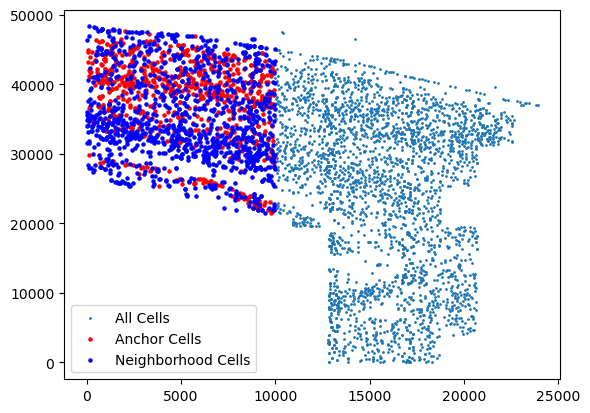

Number of neighborhoods found for each anchor: [315, 308, 351, 223, 295, 308, 257, 473, 145, 495, 185, 180, 248, 185, 322, 256, 363, 193, 272, 256, 353, 272, 194, 397, 167, 270, 148, 280, 294, 434, 307, 298, 434, 502, 268, 222, 338, 403, 333, 298, 216, 237, 285, 125, 191, 379, 386, 285, 233, 388, 439, 265, 305, 286, 301, 191, 309, 264, 216, 281, 286, 291, 259, 301, 251, 305, 255, 261, 186, 201, 251, 268, 235, 309, 261, 300, 262, 261, 233, 271, 200, 187, 217, 291, 232, 214, 191, 205, 268, 205, 184, 196, 295, 247, 200, 230, 337, 328, 272, 285, 227, 499, 194, 341, 312, 184, 314, 261, 207, 214, 253, 301, 259, 290, 218, 319, 221, 156, 431, 222, 258, 339, 253, 231, 317, 217, 239, 478, 212, 265, 310, 260, 352, 276, 170, 230, 337, 118, 261, 367, 314, 304, 303, 252, 274, 324, 244, 278, 431, 256, 253, 251, 250, 286, 271, 294, 350, 255, 132, 181, 357, 270, 317, 247, 367, 311, 197, 219, 298, 177, 302, 265, 289, 345, 455, 331, 235, 237, 492, 223, 337, 345, 245, 271, 300, 325, 222, 233, 230, 427, 35

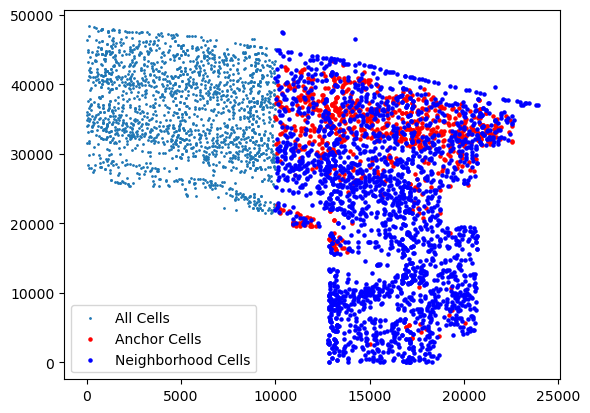

In [12]:
neighborhood_feature_fn = functools.partial(neighborhood_to_marker, markers=marker_genes)
all_sample_features = featurize_samples(sample_dfs,neighborhood_feature_fn,5000,'is_anchor','x','y')

In [13]:
all_sample_features

Syt6  Cpne5  Kcnip2  Tbr1  Hexb  Lamp5  Plp1  Gad2  \
(sample_1, cell_6195)   256    221     302   321   283    280   252   300   
(sample_1, cell_5719)   161    166     214   233   177    205   116   213   
(sample_1, cell_3901)   277    220     297   332   294    294   297   316   
(sample_1, cell_3477)   113    133     157   172   152    155    97   170   
(sample_1, cell_5857)   199    229     275   282   240    264   168   265   
...                     ...    ...     ...   ...   ...    ...   ...   ...   
(sample_2, cell_1568)   183    159     233   236   194    223   171   225   
(sample_2, cell_85)     154     75     212   218   188    211   158   207   
(sample_2, cell_3863)   154    130     200   204   179    201   153   196   
(sample_2, cell_3635)   173    178     214   215   181    213   151   197   
(sample_2, cell_260)    229    156     300   304   258    294   227   288   

                       Tmem2  Cnr1  ...  Apln  Pdgfra  Pthlh  Crh  Crhbp  \
(sample_1, cell_6195)    246   266  ...   221     191    164  149    128   
(sample_1, cell_5719)    159   196  ...   161     169    145  139    121   
(sample_1, cell_3901)    269   262  ...   260     211    159  160    129   
(sample_1, cell_3477)    139   159  ...   140     138    116  108     96   
(sample_1, cell_5857)    230   262  ...   221     220    196  177    162   
...                      ...   ...  ...   ...     ...    ...  ...    ...   
(sample_2, cell_1568)    203   227  ...   227     202    178  199    152   
(sample_2, cell_85)      181   195  ...   212     158    146  171    133   
(sample_2, cell_3863)    165   181  ...   173     145    128  143    113   
(sample_2, cell_3635)    178   206  ...   196     166    152  158    132   
(sample_2, cell_260)     263   287  ...   293     245    223  255    190   

                       Bmp4  Ttr  Itpr2  Flt1  Sox10  
(sample_1, cell_6195)   101  199    184    53    252  
(sample_1, cell_5719)   107  171    169    60    190  
(sample_1, cell_3901)   122  247    213    72    286  
(sample_1, cell_3477)    80  138    127    64    143  
(sample_1, cell_5857)   130  213    194    71    237  
...                     ...  ...    ...   ...    ...  
(sample_2, cell_1568)   128  207    180    89    218  
(sample_2, cell_85)      89  180    161    88    202  
(sample_2, cell_3863)    70  159    145    61    165  
(sample_2, cell_3635)    95  185    148    70    175  
(sample_2, cell_260)    149  254    239   118    283  

[1413 rows x 33 columns]

In [14]:
def make_nearest_neighbor_graph(sample_features, sample_dfs, sample_idx, x_col, y_col, z_col=None):
    sample_idxs = sample_features.index.map(lambda x: x[0])
    sample_rows = sample_features[sample_idxs == sample_idx]
    cell_idx = sample_rows.index.map(lambda x: x[1])
    if z_col is None:
        coords = [x_col, y_col]
    else:
        coords = [x_col, y_col, z_col]
    cell_coords = sample_dfs[sample_idx].loc[cell_idx][coords].values
    vor = Voronoi(cell_coords)
    num_edges = vor.ridge_points.shape[0]
    num_nodes = len(cell_coords)
    src_nodes = vor.ridge_points[:, 0]
    dst_nodes = vor.ridge_points[:, 1]
    coord_difference = cell_coords[src_nodes] - cell_coords[dst_nodes]
    edge_lengths = np.sqrt(np.sum(coord_difference**2.0, axis=1))
    assert len(edge_lengths) == num_edges
    return num_nodes, src_nodes, dst_nodes, edge_lengths
def make_minimum_spaning_tree_mask(num_nodes, src_nodes, dst_nodes,
                                   edge_lengths):
    num_edges = len(src_nodes)
    adjacency_matrix = coo_matrix((edge_lengths, (src_nodes, dst_nodes)),
                                  shape=(num_nodes, num_nodes)).tocsr()
    edge_index = coo_matrix((np.arange(num_edges), (src_nodes, dst_nodes)),
                            shape=(num_nodes, num_nodes)).tocsr()
    spanning_tree = minimum_spanning_tree(adjacency_matrix)
    mst_mask = np.asarray(edge_index[spanning_tree.nonzero()]).squeeze()
    return mst_mask
def make_difference_matrix(num_nodes, src_nodes, dst_nodes):
    num_edges = len(src_nodes)
    rows = np.hstack([np.arange(num_edges), np.arange(num_edges)])
    cols = np.hstack([src_nodes, dst_nodes])
    values = np.hstack([np.ones(num_edges), -1 * np.ones(num_edges)])
    difference_matrix = coo_matrix(
        (values, (rows, cols)), shape=(num_edges, num_nodes)).tocsr()
    return difference_matrix
def make_merged_difference_matrices(sample_features, sample_dfs,
                                    x_col, y_col, z_col=None,
                                    reduce_to_mst=True):
    difference_matrices = dict()
    sample_idxs = sample_features.index.map(lambda x: x[0])
    for sample_idx in set(sample_idxs):
        graph = make_nearest_neighbor_graph(
            sample_features, sample_dfs, sample_idx, x_col, y_col, z_col=z_col)
        num_nodes, src_nodes, dst_nodes, edge_lengths = graph
        difference_matrix = make_difference_matrix(
            num_nodes, src_nodes, dst_nodes)
        if reduce_to_mst:
            mst_mask = make_minimum_spaning_tree_mask(
                num_nodes, src_nodes, dst_nodes, edge_lengths)
            difference_matrix = difference_matrix[mst_mask, :]
        difference_matrices[sample_idx] = difference_matrix
    return difference_matrices


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import palettable.cartocolors.qualitative as qual_palettes
import pandas as pd
import pickle
import scipy
import seaborn as sns

blue = sns.color_palette()[0]
green = sns.color_palette()[1]
red = sns.color_palette()[2]


def make_rgb_channel(data, hue):
    def normalize(arr):
        arr = arr - np.percentile(arr, 5)
        return np.clip(arr / np.percentile(arr, 97), 0, 1)
    color_data = np.zeros(list(data.shape) + [3])
    color_data[..., 0] = hue
    color_data[..., 1] = 1
    color_data[..., 2] = normalize(data)
    return colors.hsv_to_rgb(color_data)


def make_multichannel_im(data, starting_hue=0.):
    num_channels = data.shape[-1]
    data_shape = data.shape[:-1]
    s = []
    for i in range(num_channels):
        hue = (starting_hue + (i * 1. / num_channels))
        if hue > 1:
            hue -= 1
        s.append(make_rgb_channel(data[..., i], hue))
    s = np.stack(s)
    s[s < 1e-5] = np.NAN
    normalized_s = (np.nanmean(s**5, axis=0))**(0.2)
    return normalized_s


def plot_one_tumor_false_color(ax, tumor_idx, topic_weights, patient_dfs):
    mask = topic_weights.index.map(lambda x: x[0]) == tumor_idx
    tumor_topics = topic_weights[mask]
    rgb_points = pd.DataFrame(make_multichannel_im(tumor_topics.values,
                                                   starting_hue=0.15),
                              index=tumor_topics.index)
    cell_coords = patient_dfs[tumor_idx]
    immune_coords = cell_coords[cell_coords.isimmune]
    cell_indices = rgb_points.index.map(lambda x: x[1])
    coords = patient_dfs[tumor_idx].loc[cell_indices]
    ax.scatter(immune_coords['y'], -immune_coords['x'],
               s=5, c='k', label='Immune', alpha=0.1)
    ax.scatter(coords['y'], -coords['x'], s=3, c=rgb_points.values)
    ax.set_title("Tumor %d" % tumor_idx)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)


def plot_one_tumor_cluster(ax, tumor_idx, features, patient_dfs,
                           cluster_colors=[green, red]):
    cell_coords = patient_dfs[tumor_idx]
    immune_coords = cell_coords[cell_coords.isimmune]
    ax.scatter(immune_coords['y'], -immune_coords['x'], s=5, c='k',
               label='Immune', alpha=0.1)
    clusters = features.cluster.unique()
    for i, color in zip(clusters, cluster_colors):
        cluster_cell_indices = features[features.cluster == i].index.map(
            lambda x: x[1])
        coords = patient_dfs[tumor_idx].loc[cluster_cell_indices]
        ax.scatter(coords['y'], -coords['x'], s=3,
                   c=color, label='Cluster %d' % i)
    ax.set_title("Tumor %d" % tumor_idx)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)


def plot_one_tumor_topic(ax, tumor_idx, topic_weights, patient_dfs):
    cell_coords = patient_dfs[tumor_idx]
    immune_coords = cell_coords[cell_coords.isimmune]
    cell_indices = topic_weights.index.map(lambda x: x[1])
    coords = patient_dfs[tumor_idx].loc[cell_indices]
    ax.scatter(immune_coords['y'], -immune_coords['x'],
               s=5, c='k', label='Immune', alpha=0.1)
    ax.scatter(coords['y'], -coords['x'], s=2, c=topic_weights, cmap="Reds",
               label='Topic weight')
    ax.set_title("Tumor %d" % tumor_idx)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)


def plot_one_tumor_all_topics(ax, tumor_idx, topic_weights, patient_dfs):
    color_palette = qual_palettes.Bold_10.mpl_colors
    colors = np.array(color_palette[:topic_weights.shape[1]])
    cell_coords = patient_dfs[tumor_idx]
    immune_coords = cell_coords[cell_coords.isimmune]
    cell_indices = topic_weights.index.map(lambda x: x[1])
    coords = patient_dfs[tumor_idx].loc[cell_indices]
    ax.scatter(immune_coords['y'], -immune_coords['x'],
               s=5, c='k', label='Immune', alpha=0.1)
    ax.scatter(coords['y'], -coords['x'], s=2,
               c=colors[np.argmax(np.array(topic_weights), axis=1), :])
    ax.set_title("Tumor %d" % tumor_idx)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)


def plot_tumors(features_df, plot_fn):
    sns.set_style("white")
    tumor_idx = features_df.index.map(lambda x: x[0])
    tumor_set = np.unique(tumor_idx)
    num_rows = (len(tumor_set) // 4) + 1
    _, axes = plt.subplots(num_rows, 4, figsize=(4 * 4, num_rows * 4))

    for i, tumor in enumerate(tumor_set):
        row = i // 4
        col = i % 4
        plot_fn(axes[row, col], tumor, features_df[tumor_idx == tumor])
    sns.despine(left=True, bottom=True)


def plot_samples_in_a_row(features_df, plot_fn, patient_dfs, tumor_set=None):
    sns.set_style("white")
    tumor_idx = features_df.index.map(lambda x: x[0])
    if tumor_set is None:
        tumor_set = np.unique(tumor_idx)

    n = len(tumor_set)
    num_rows = 1
    num_cols = (len(tumor_set) // num_rows)
    _, axes = plt.subplots(
        num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

    for i, tumor in enumerate(tumor_set):
        plot_fn(axes[i], tumor, features_df[tumor_idx == tumor], patient_dfs)

    sns.despine(left=True, bottom=True)


def plot_bcell_topic_multicolor(ax, sample_idx, topic_weights, spleen_dfs):
    color_palette = qual_palettes.Bold_10.mpl_colors
    colors = np.array(color_palette[:topic_weights.shape[1]])
    cell_coords = spleen_dfs[sample_idx]
    non_b_coords = cell_coords[~cell_coords.isb]
    ax.scatter(
        non_b_coords['sample.Y'],
        non_b_coords['sample.X'],
        s=1,
        c='k',
        marker='x',
        label='Non-B',
        alpha=.2)

    cell_indices = topic_weights.index.map(lambda x: x[1])
    coords = spleen_dfs[sample_idx].loc[cell_indices]

    ax.scatter(coords['sample.Y'], coords['sample.X'], s=3,
               c=colors[np.argmax(np.array(topic_weights), axis=1), :])

    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.set_title(f'Sample {sample_idx}')


def _standardize_topics(topics):
    topics = topics.T
    topics = topics - topics.mean(axis=1, keepdims=True)
    topics = topics / topics.std(axis=1, keepdims=True)
    return topics


def plot_topics_heatmap(topics, features, normalizer=None):
    n_topics = topics.shape[0]
    if normalizer is not None:
        topics = normalizer(topics)
    else:
        topics = _standardize_topics(topics)

    topics = pd.DataFrame(topics, index=features,
                          columns=['Topic %d' % x for x in range(n_topics)])
    sns.heatmap(topics, square=True, cmap='RdBu')


def get_tumor_markers(tumor_features, patient_dfs):
    tumor_idx = tumor_features.index.map(lambda x: x[0])
    tumor_set = np.unique(tumor_idx)
    num_rows = (len(tumor_set) // 4) + 1
    markers = []
    for i, tumor in enumerate(tumor_set):
        cell_idx = tumor_features[tumor_idx == tumor].index.map(lambda x: x[1])
        feature_df = patient_dfs[tumor].loc[cell_idx]
        feature_df = feature_df.set_index(
            tumor_features[tumor_idx == tumor].index)
        markers.append(feature_df)
    markers = pd.concat(markers)
    return markers


def plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs,
                         difference_matrices):
    sns.set_style("white")
    tumor_idxs = features_df.index.map(lambda x: x[0])
    tumor_rows = features_df[tumor_idxs == tumor_idx]
    cell_idx = tumor_rows.index.map(lambda x: x[1])
    cell_coords = patient_dfs[tumor_idx].loc[cell_idx][['x', 'y']].values
    difference_matrix = difference_matrices[tumor_idx]
    for i in range(difference_matrix.shape[0]):
        src_idx = difference_matrix[i].nonzero()[1][0]
        dst_idx = difference_matrix[i].nonzero()[1][1]
        src_x, src_y = cell_coords[src_idx, :]
        dst_x, dst_y = cell_coords[dst_idx, :]
        ax.plot([src_x, dst_x], [-src_y, -dst_y])

    ax.set_aspect(1)
    ax.set_title(f"Sample {tumor_idx} adjacency")
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)


In [16]:
ALPHA = 0.1
BETA = 0.5
MAXLSITER = 60
MAXITER = 100
#TOL = 1e-3
ADMM_RESIDUAL_RATIO_BOUND = 4.0
ADMM_RHO_SCALE = 2.0


def split_gamma(gamma, n, k, l):
    xi = np.reshape(gamma[0:n * k], [n, k])
    chi = np.reshape(gamma[n * k: n * k + l * k], [l, k])
    return xi, chi


def make_A(D, k):
    return scipy.sparse.kron(D, np.eye(k))


def make_C(D, k):
    l = D.shape[0]
    A = make_A(D, k)
    I = scipy.sparse.eye(l * k)
    As = scipy.sparse.vstack((A, -A))
    Is = scipy.sparse.vstack((-I, -I))
    return scipy.sparse.hstack((As, Is))


def f0(gamma, e, rho, s):
    # n documents, k topics, l ties between documents
    n, k = e.shape
    l = s.shape[0]
    xi, chi = split_gamma(gamma, n, k, l)
    objective = rho / 2 * np.sum((xi - e)**2.0)
    objective += np.sum(scipy.sparse.diags(s, 0).dot(chi))
    return objective


def gradient_f0(gamma, e, rho, s):
    n, k = e.shape
    l = s.shape[0]
    xi, chi = split_gamma(gamma, n, k, l)
    gxi = rho * (xi - e)
    gchi = scipy.sparse.diags(s, 0).dot(np.ones((l, k)))
    gxi = np.reshape(gxi, (n * k, 1))
    gchi = np.reshape(gchi, (l * k, 1))
    return np.vstack((gxi, gchi))


def hessian_f0(gamma, e, rho, s):
    n, k = e.shape
    l = s.shape[0]
    xi, chi = split_gamma(gamma, n, k, l)
    nabla2_xi = rho * scipy.sparse.eye(n * k)
    zeros_nk_lk = scipy.sparse.coo_matrix((n * k, l * k))
    zeros_lk_lk = scipy.sparse.coo_matrix((l * k, l * k))
    H = scipy.sparse.vstack((scipy.sparse.hstack((nabla2_xi, zeros_nk_lk)),
                             scipy.sparse.hstack((zeros_nk_lk.T, zeros_lk_lk))))
    return H


def r_dual(gamma, u, C, e, rho, s):
    g = gradient_f0(gamma, e, rho, s)
    r = np.squeeze(g) + np.squeeze((C.T.dot(u)))
    return r


def r_cent(gamma, u, C, t):
    f1 = C.dot(gamma)
    return -np.squeeze(scipy.sparse.diags(u, 0).dot(f1)) - 1. / t


def compute_r(gamma, u, C, e, rho, s, t):
    r1 = r_dual(gamma, u, C, e, rho, s)
    r2 = r_cent(gamma, u, C, t)
    r = -np.hstack((r1, r2))
    return r


def build_linear_system(gamma, u, C, e, rho, s, t):
    n, k = e.shape
    H = hessian_f0(gamma, e, rho, s)
    uC = scipy.sparse.diags(np.squeeze(u), 0).dot(C)
    Cg = scipy.sparse.diags(np.squeeze(C.dot(gamma)))
    M = scipy.sparse.vstack((scipy.sparse.hstack((H, C.T)),
                             scipy.sparse.hstack((-uC, -Cg)))).tocsr()
    r = compute_r(gamma, u, C, e, rho, s, t)
    return M, r


def split_primal_dual_vars(z, n, k, l):
    gamma = z[:n * k + l * k]
    u = z[n * k + l * k:]
    return np.squeeze(gamma), np.squeeze(u)


def gap(gamma, C, u):
    return -np.sum(C.dot(np.squeeze(gamma)) * np.squeeze(u))


def spsolve(M, r):
    perm = scipy.sparse.csgraph.reverse_cuthill_mckee(M, True)
    inv_perm = np.argsort(perm)
    M = M[perm, :][:, perm]
    r = r[perm]
    delta = scipy.sparse.linalg.spsolve(M, r)
    return delta[inv_perm]


def line_search(gamma, u, C, e, rho, s, t, l):
    n, k = e.shape
    M, r = build_linear_system(gamma, u, C, e, rho, s, t)
    delta = spsolve(M, r)
    dgamma, du = split_primal_dual_vars(delta, n, k, l)
    step_max = 1.0
    neg_du = du < 0
    if np.any(neg_du):
        step_max = np.min((step_max, np.min(u[neg_du] / (-du[neg_du]))))

    step = step_max * 0.99
    for lsit in range(MAXLSITER):
        new_gamma = gamma + step * dgamma
        new_u = u + step * du
        new_r = compute_r(new_gamma, new_u, C, e, rho, s, t)
        if (np.any(C.dot(new_gamma) > 0) or
                np.linalg.norm(new_r) > (1 - ALPHA * step) * np.linalg.norm(r)):
            step = step * BETA
        else:
            u = new_u
            gamma = new_gamma
            r = new_r
            break
    if lsit == MAXLSITER - 1:
        logging.warning('Line search failed.')
    return gamma, u, step, lsit


def primal_dual(e, rho, D, s, mu=2, verbosity=0, max_iter=MAXITER, primal_tol=1e-3):
    """ADMM.primal_dual for fusion problem (see appendix section 5.2.4)."""
    l, n = D.shape
    _, k = e.shape
    num_features_e = e.shape[0]  
    num_features_D = D.shape[1]  
    if D.shape[1] < e.shape[0]:
        logging.info("Padding D to match e's rows.")
        padding_needed = e.shape[0] - D.shape[1]
        D_adjusted = np.pad(D, ((0, 0), (0, padding_needed)), mode='constant', constant_values=0)
    else:
        D_adjusted = D 
        
    D=D_adjusted 

    assert e.shape[0] == D_adjusted.shape[1]
    

    gamma = np.hstack((np.ones(n * k), np.ones(l * k)))
    u = np.ones(2 * l * k)
    C = make_C(D, k)
    t = 1.0
    for it in range(max_iter):
        nu = gap(gamma, C, u)
        t = np.max((2 * mu / nu, t * 1.2))
        gamma, u, step, lsit = line_search(gamma, u, C, e, rho, s, t, l)
        r = np.linalg.norm(r_dual(gamma, u, C, e, rho, s)) + \
            np.linalg.norm(r_cent(gamma, u, C, t))
        if verbosity >= 3:
            logging.info(
                f'\tPrimal Dual it: {it}, gap: {nu:.6g}, t: {t:.6g}, step: {step:.6g}, res: {r:.6g}, lsit: {lsit}')
        xis, chis = split_gamma(gamma, n, k, l)
        if r < primal_tol and nu < primal_tol:
            break
    if verbosity >= 2:
        logging.info(
            f'\tPrimal Dual it: {it}, gap: {nu:.6g}, t: {t:.6g}, step: {step:.6g}, res: {r:.6g}, lsit: {lsit}')

    if it == max_iter - 1:
        logging.warn('\tPrimal dual did not converge.')
        with open('pd.dbg.pkl', 'wb') as f:
            pickle.dump((e, rho, D, s, mu), f)
        raise Exception('Stopping in admm.primal_dual')

    return gamma, u


def li(taus, r, rho):
    """Compute negative regularized dirichlet log-likelihood"""
    n, k = r.shape
    r = np.reshape(r, (n, k))
    taus = np.reshape(taus, (n, k))
    objective = np.sum(gammaln(taus))
    objective -= np.sum(gammaln(np.sum(taus, axis=1)))
    objective += rho / 2 * np.sum((taus - r)**2.0)
    return objective


def gradient_li(taus, r, rho):
    n, k = r.shape
    r = np.reshape(r, (n, k))
    taus = np.reshape(taus, (n, k))
    gtau = (digamma(taus) - digamma(np.sum(taus, axis=1, keepdims=True)))
    gtau += rho * (taus - r)
    return np.reshape(gtau, (-1, 1))


def assemble_block_diag(mats):
    row = []
    col = []
    data = []
    offset = 0
    nrows, ncols = mats[0].shape
    row_idx, col_idx = np.meshgrid(range(nrows), range(ncols))
    for a in mats:
        row.append((row_idx + offset).flatten())
        col.append((col_idx + offset).flatten())
        data.append(a.flatten())
        offset += nrows
    data = np.hstack(data)
    row = np.hstack(row)
    col = np.hstack(col)
    return scipy.sparse.coo_matrix((data, (row, col)))


def hessian_li(taus, r, rho):
    n, k = r.shape
    taus = np.reshape(taus, [n, k])
    blocks = []
    for i in range(n):
        block = np.diag(
            polygamma(1, taus[i, :]) + rho) - polygamma(1, np.sum(taus[i, :]))
        blocks.append(block)
    H = assemble_block_diag(blocks)
    return H


def get_update_step(taus, r, rho):
    n, k = r.shape
    g = gradient_li(taus, r, rho)
    taus = np.reshape(taus, [n, k])
    q = polygamma(1, taus) + rho
    z = -polygamma(1, np.sum(taus, axis=1, keepdims=True))
    iq = np.reshape(1 / q, [n, k])
    g = np.reshape(g, [n, k])
    b = np.sum(g * iq, axis=1, keepdims=True) / \
        (1 / z + np.sum(iq, axis=1, keepdims=True))
    step = (g - b) * iq
    sc = np.sum(step * g)
    return np.reshape(step, [-1, 1]), sc, g


def newton_regularized_dirichlet(
        rho, r, max_iter=30, ls_iter=10, tol=1e-4, verbose=False, alpha=0.01, beta=0.5, verbosity=0):
    n, k = r.shape
    taus = np.ones((np.prod(r.shape), 1))
    new_li = li(taus, r, rho)
    for it in range(max_iter):
        old_li = new_li
        step, sc, g = get_update_step(taus, r, rho)
        g_norm = np.linalg.norm(g)
        t = 1.0
        neg = (taus - step) < 0
        if len(taus[neg]) > 0:
            t = np.min([t, 0.99 * np.min(taus[neg] / step[neg])])

        for ls_it in range(ls_iter):
            new_taus = taus - t * step
            new_li = li(new_taus, r, rho)
            if verbosity >= 3:
                logging.info(f'  Line search: {ls_it} neg.log.lik.: {new_li}'
                             f' old neg.log.lik.:{old_li}'
                             f' sc:{sc} t:{t}')
            # Armijo-Goldstein condition
            if new_li > old_li - t * alpha * sc:
                t = t * beta
            else:
                taus = new_taus
                break

        if verbosity >= 3:
            logging.info(
                f'\tRegularized Dirichlet iter: {it} objective: {new_li:.4g} gradient norm: {g_norm:.4g}')
        if new_li > old_li:
            logging.info(
                f' Objective not reducing iter: {it} old: {old_li:.4g} new: {new_li:.4g}')
            with open('nrd.dbg.pkl', 'wb') as f:
                pickle.dump((rho, r), f)
            raise Exception('Stopping in admm.newton_regularized_dirichlet.')

        if old_li - new_li < tol:
            break
    if verbosity >= 2:
        logging.info(f'\tRegularized Dirichlet iter: {it:} objective: {new_li:.4g}'
                     f' gradient norm: {g_norm:.4g} sc: {sc:.4g}')
    if it == max_iter - 1:
        logging.warn(' Regularized Dirichlet did not converge.')
        logging.info(f'new_li:{new_li} old_li:{old_li}')
        with open('nrd.dbg.pkl', 'wb') as f:
            pickle.dump((rho, r), f)
        raise Exception('Stopping in admm.newton_regularized_dirichlet.')

    return taus


def update_e(taus, v, rho):
    return taus + 1 / rho * v


def update_xis(es, rho, D, s, max_iter=100, verbosity=0, mu=2, primal_tol=1e-3):
    n, k = es.shape
    l = D.shape[0]
    xis = []
    for i in range(k):
        e = es[:, [i]]
        gamma, _ = primal_dual(e, rho, D, s, max_iter=max_iter, mu=mu,
                               verbosity=verbosity, primal_tol=primal_tol)
        xi, _ = split_gamma(gamma, n, 1, l)
        xis.append(xi)
    return np.concatenate(xis, axis=1)


def update_r(xis, v, cs, rho):
    return xis - 1 / rho * v + 1 / rho * cs


def update_tau(r, rho, verbosity=0, max_iter=20, ls_iter=10):
    new_taus = newton_regularized_dirichlet(
        rho, r, max_iter=max_iter, ls_iter=ls_iter, verbosity=verbosity)
    assert np.all(new_taus > 0)
    return np.reshape(new_taus, r.shape)


def update_v(v, taus, xis, rho):
    return v + rho * (taus - xis)


def primal_objective(taus, cs, s, D):
    n, k = np.shape(cs)
    objective = np.sum(gammaln(taus))
    objective -= np.sum(gammaln(np.sum(taus, axis=1)))
    objective -= np.sum(np.multiply(taus, cs))
    chis = np.abs(D @ taus)
    objective += np.sum(scipy.sparse.diags(s, 0).dot(chis))
    return objective


def admm(cs, D, s, rho, verbosity=0, max_iter=15,
         max_dirichlet_iter=20, max_dirichlet_ls_iter=10,
         max_primal_dual_iter=400,
         mu=2, primal_tol=1e-3, threshold=None):
    if threshold is not None:
        assert 0 < threshold < 1
    taus = np.ones(cs.shape)
    xis = np.ones(cs.shape)
    v = np.zeros(cs.shape)
    start = time.time()
    for i in range(max_iter):
        es = update_e(taus, v, rho)
        start_xis = time.time()
        xis_old, taus_old = xis, taus
        xis = update_xis(es, rho, D, s, max_iter=max_primal_dual_iter,
                         verbosity=verbosity, mu=mu, primal_tol=primal_tol)
        if verbosity >= 1:
            duration = time.time() - start_xis
            logging.info(f'\tADMM Primal-Dual Fusion took:{duration:.2f} seconds')
        r = update_r(xis, v, cs, rho)
        start_tau = time.time()
        taus = update_tau(
            r,
            rho,
            max_iter=max_dirichlet_iter,
            ls_iter=max_dirichlet_ls_iter,
            verbosity=verbosity)
        if verbosity >= 1:
            duration = time.time() - start_tau
            logging.info(
                f'\tADMM Newton Regularized Dirichlet took:{duration:.2f} seconds')
        v = update_v(v, taus, xis, rho)
        primal_residual = np.linalg.norm(taus - xis)
        dual_residual = rho * (np.linalg.norm(xis_old - xis) +
                               np.linalg.norm(taus_old - taus))
        residual_ratio = primal_residual / dual_residual

        if residual_ratio > ADMM_RESIDUAL_RATIO_BOUND:
            rho *= ADMM_RHO_SCALE
        elif residual_ratio < 1 / ADMM_RESIDUAL_RATIO_BOUND:
            rho /= ADMM_RHO_SCALE

        objective_old = primal_objective(taus_old, cs, s, D)
        objective = primal_objective(taus, cs, s, D)
        pct_change = abs(objective_old - objective) / objective_old

        if verbosity >= 1:
            norm_v = np.linalg.norm(v)
            duration = time.time() - start
            logging.info(f'\nADDM it:{i} primal res.:{primal_residual:.5g}'
                         f' dual res.:{dual_residual:.5g}.'
                         f' norm of v:{norm_v:.5g}'
                         f' objective: {objective:.5g}'
                         f' old objective: {objective_old:.5g}'
                         f' percent change: {pct_change:.5g}'
                         f' rho: {rho:.5f}'
                         f' Time since start:{duration:.2f} seconds\n')

        if threshold is not None:
            if pct_change < threshold:
                break

    return xis


In [17]:
from spatial_lda.online_lda import LatentDirichletAllocation


def _update_xi(counts, diff_matrix, diff_penalty, sample_id, verbosity=0, max_iter=15,
               max_primal_dual_iter=400, max_dirichlet_iter=20, max_dirichlet_ls_iter=10,
               rho=1e-1, mu=2.0, primal_tol=1e-3, threshold=None):
    if verbosity >= 1:
        logging.info(f'>>> Infering topic weights for sample {sample_id}')
    weight = 1. / diff_penalty
    cs = digamma(counts) - digamma(np.sum(counts, axis=1, keepdims=True))
    s = weight * np.ones(diff_matrix.shape[0])
    result = admm(cs, diff_matrix, s, rho, verbosity=verbosity, mu=mu, primal_tol=primal_tol,
                       max_dirichlet_iter=max_dirichlet_iter, max_dirichlet_ls_iter=max_dirichlet_ls_iter,
                       max_primal_dual_iter=max_primal_dual_iter, max_iter=max_iter,
                       threshold=threshold)
    if verbosity >= 1:
        logging.info(f'>>> Done inferring topic weights for sample {sample_id}')
    return result


def _wrap_update_xi(inputs):
    return _update_xi(**inputs)


def _update_xis(sample_features, difference_matrices, difference_penalty, gamma,
                n_parallel_processes, verbosity, primal_dual_mu=2, admm_rho=0.1,
                max_primal_dual_iter=400, max_dirichlet_iter=20, max_dirichlet_ls_iter=10,
                max_iter=15, primal_tol=1e-3, threshold=None):
    sample_idxs = sample_features.index.map(lambda x: x[0])
    new_xis = np.zeros_like(gamma)
    if n_parallel_processes == None:
        n_parallel_processes=1
    if n_parallel_processes > 1:
        with Pool(n_parallel_processes) as pool:
            unique_idxs = np.unique(sample_idxs)
            sample_masks = [
                sample_idxs == sample_idx for sample_idx in unique_idxs]
            sample_counts = [gamma[sample_mask, :]
                             for sample_mask in sample_masks]
            sample_diff_matrices = [difference_matrices[sample_idx]
                                    for sample_idx in unique_idxs]
            diff_penalties = [difference_penalty for _ in unique_idxs]
            tasks = OrderedDict((('counts', sample_counts),
                                 ('diff_matrix', sample_diff_matrices),
                                 ('diff_penalty', diff_penalties),
                                 ('sample_id', unique_idxs),
                                 ('max_iter', itertools.repeat(max_iter)),
                                 ('max_primal_dual_iter', itertools.repeat(max_primal_dual_iter)),
                                 ('max_dirichlet_iter', itertools.repeat(max_dirichlet_iter)),
                                 ('max_dirichlet_ls_iter', itertools.repeat(max_dirichlet_ls_iter)),
                                 ('verbosity', itertools.repeat(0)),                               
                                 ('rho', itertools.repeat(admm_rho)),
                                 ('mu', itertools.repeat(primal_dual_mu)),
                                 ('primal_tol', itertools.repeat(primal_tol)),
                                 ('threshold', itertools.repeat(threshold))))
            # convert into a list of keyword dictionaries
            kw_tasks = [{k: v for k, v in zip(tasks.keys(), values)}
                        for values in list(zip(*tasks.values()))]
            results = list(tqdm(pool.imap(_wrap_update_xi, kw_tasks),
                                total=len(unique_idxs),
                                position=1,
                                desc='Update xi'))
            new_xis = np.concatenate(results)
    else:
        for sample_idx in np.unique(sample_idxs):
            sample_mask = sample_idxs == sample_idx
            sample_counts = gamma[sample_mask, :]
            sample_diff_matrix = difference_matrices[sample_idx]
            new_xis[sample_mask] = _update_xi(sample_counts,
                                              sample_diff_matrix,
                                              difference_penalty,
                                              sample_idx,
                                              max_primal_dual_iter=max_primal_dual_iter,
                                              max_dirichlet_iter=max_dirichlet_iter,
                                              max_dirichlet_ls_iter=max_dirichlet_ls_iter,
                                              max_iter=max_iter,
                                              verbosity=verbosity,
                                              rho=admm_rho,
                                              mu=primal_dual_mu,
                                              primal_tol=primal_tol,
                                              threshold=threshold)
    return new_xis


def train(sample_features, difference_matrices, n_topics, difference_penalty=1,
          max_primal_dual_iter=400, max_dirichlet_iter=20, max_dirichlet_ls_iter=10,
          max_lda_iter=5, max_admm_iter=15, n_iters=3, n_parallel_processes=1, verbosity=0,
          primal_dual_mu=2, admm_rho=1.0, primal_tol=1e-3, threshold=None):

    start_time = time.time()
    xis = None
    for i in range(n_iters):
        logging.info(f'>>> Starting iteration {i}')
        m_step_start_time = time.time()
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0,
                                        n_jobs=n_parallel_processes, max_iter=max_lda_iter,
                                        doc_topic_prior=xis)
        lda.fit(sample_features.values)
        gamma = lda._unnormalized_transform(sample_features.values)
        m_duration = time.time() - m_step_start_time
        logging.info(f'>>> Iteration {i}, M-step took {m_duration} seconds.')
        e_step_start_time = time.time()
        xis = _update_xis(sample_features=sample_features,
                          difference_matrices=difference_matrices,
                          difference_penalty=difference_penalty,
                          gamma=gamma,
                          n_parallel_processes=n_parallel_processes,
                          max_iter=max_admm_iter,
                          max_primal_dual_iter=max_primal_dual_iter,
                          max_dirichlet_iter=max_dirichlet_iter,
                          max_dirichlet_ls_iter=max_dirichlet_ls_iter,
                          verbosity=verbosity,
                          primal_dual_mu=primal_dual_mu,
                          admm_rho=admm_rho,
                          primal_tol=primal_tol,
                          threshold=threshold)
        e_duration = time.time() - e_step_start_time
        logging.info(f'>>> Iteration {i}, E-step took {e_duration} seconds.')

    last_m_step_start = time.time()
    columns = ['Topic-%d' % i for i in range(n_topics)]
    lda.topic_weights = pd.DataFrame(lda.fit_transform(sample_features.values),
                                     index=sample_features.index,
                                     columns=columns)
    logging.info(f'>>> Final M-step took {time.time() - last_m_step_start} seconds.')
    logging.info(f'>>> Training took {time.time() - start_time} seconds.')
    return lda




def _topic_name(i):
    return f'Topic-{i}'


def infer(components, sample_features, difference_matrices, difference_penalty=1,
          max_primal_dual_iter=400, max_dirichlet_iter=20, max_dirichlet_ls_iter=10,
          max_admm_iter=15, n_parallel_processes=1):
    start_time = time.time()
    logging.info('>>> Starting inference')
    n_topics = components.shape[0]
    complete_lda = LatentDirichletAllocation(n_components=n_topics,
                                             random_state=0,
                                             n_jobs=n_parallel_processes,
                                             max_iter=2,
                                             doc_topic_prior=None)
    complete_lda.set_components(components)
    gamma = complete_lda._unnormalized_transform(sample_features.values)
    xis = _update_xis(sample_features,
                      difference_matrices,
                      difference_penalty,
                      max_iter=max_admm_iter,
                      max_primal_dual_iter=max_primal_dual_iter,
                      max_dirichlet_iter=max_dirichlet_iter,
                      max_dirichlet_ls_iter=max_dirichlet_ls_iter,
                      gamma=gamma,
                      n_parallel_processes=n_parallel_processes,
                      verbosity=0)
    complete_lda.doc_topic_prior_ = xis
    columns = [_topic_name(i) for i in range(n_topics)]
    topic_weights = pd.DataFrame(complete_lda.transform(sample_features.values),
                                 index=sample_features.index,
                                 columns=columns)
    complete_lda.topic_weights = topic_weights
    logging.info(f'>>> Inference took {time.time() - start_time} seconds.')
    return complete_lda


def get_component_mapping(stats_1, stats_2):
    similarity = stats_1 @ stats_2.T
    assignment = linear_sum_assignment(-similarity)
    mapping = {k: v for k, v in zip(*assignment)}
    return mapping


def get_consistent_orders(stats_list):
    d = stats_list[0].shape[1]
    n_topics = [stats.shape[0] for stats in stats_list]
    assert all([stats.shape[1] == d for stats in stats_list])
    assert all([n1 <= n2 for n1, n2 in zip(n_topics[:-1], n_topics[1:])])
    orders = [list(range(n_topics[0]))]
    for stats_1, stats_2 in zip(stats_list[:-1], stats_list[1:]):
        n_topics_1 = stats_1.shape[0]
        n_topics_2 = stats_2.shape[0]
        mapping = get_component_mapping(stats_1[orders[-1], :], stats_2)
        mapped = mapping.values()
        unmapped = set(range(n_topics_2)).difference(mapped)
        order = [mapping[k] for k in range(n_topics_1)] + list(unmapped)
        orders.append(order)
    return orders


def apply_order_to_model(model, order):
    # Check if model components are None
    if model.components_ is None:
        logging.error("Model components are None")
        return  # or handle as needed

    # Reorder model components
    model.components_ = model.components_[order, :]
    if not np.isscalar(model.doc_topic_prior):
        model.doc_topic_prior = model.doc_topic_prior[:, order]
    model.doc_topic_prior_ = model.doc_topic_prior_[:, order]

    # Create a mapping for topic names
    mapper = {_topic_name(j): _topic_name(i) for i, j in enumerate(order)}
    
    # Rename columns of topic weights
    _df = model.topic_weights
    if _df is not None:
        _df.rename(columns=mapper, inplace=True)
        model.topic_weights = _df.reindex(sorted(_df.columns), axis=1)
    else:
        logging.error("topic_weights DataFrame is None")





def order_topics_consistently(models, use_topic_weights=True):
    if use_topic_weights:
        stats_list = [model.topic_weights.values.T for model in models]
    else:
        stats_list = [model.components_ for model in models]

    orders = get_consistent_orders(stats_list)
    for model, order in zip(models, orders):
        apply_order_to_model(model, order)


In [18]:
difference_matrices = make_merged_difference_matrices(all_sample_features,sample_dfs,
                                                             'x', 'y')

In [19]:
all_sample_idxs = all_sample_features.index.map(lambda x: x[0])
TRAIN_SIZE_FRACTION = 0.99
_sets = train_test_split(all_sample_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_sample_idxs)
train_cells_features, test_cells__features = _sets
train_difference_matrices = make_merged_difference_matrices(
    train_cells_features, sample_dfs,
    'x', 'y')
sample_idxs = train_cells_features.index.map(lambda x: x[0])

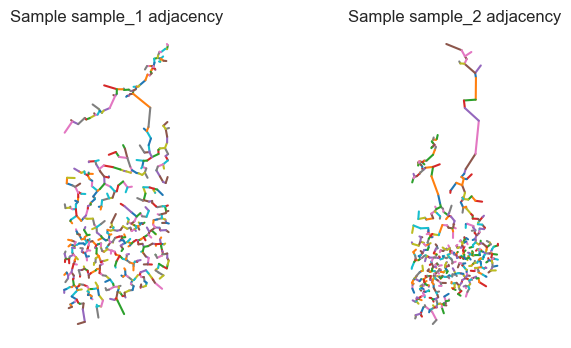

In [20]:
def make_plot_fn(difference_matrices):  
    def plot_fn(ax, sample_idxs , features_df, patient_dfs):
        plot_adjacency_graph(ax,sample_idxs , features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(difference_matrices)

plot_samples_in_a_row(all_sample_features, _plot_fn, sample_dfs, tumor_set=['sample_1', 'sample_2'])

In [21]:
N_TOPICS_LIST = [11]
spatial_lda_models = {}  
difference_penalty = 0.25  
for n_topics in N_TOPICS_LIST:
    spatial_lda_model = train(sample_features=all_sample_features, 
                                                difference_matrices=difference_matrices,
                                                difference_penalty=difference_penalty,
                                                n_topics=n_topics,
                                                n_parallel_processes=None,                                                                         
                                                verbosity=1,
                                                admm_rho=0.1,
                                                primal_dual_mu=1e+5)
    spatial_lda_models[n_topics] = spatial_lda_model
    
order_topics_consistently(spatial_lda_models.values())     

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
from sklearn.decomposition import PCA
def save_cluster_labels_to_csv(model, n_obs, n_topics):
    # Create sample indices from 1 to n_obs
    sample_indices = np.arange(1, n_obs + 1)  # 1 to n_obs
    logging.info(f"Sample indices generated: {sample_indices}")
    
    # Get topic weights and determine cluster labels
    topic_weights = model.transform(all_sample_features)
    
    if topic_weights.ndim == 2:
        cluster_labels = topic_weights.argmax(axis=1) + 1 
    else:
        raise ValueError("Expected topic_weights to be 2-dimensional.")
    
    # Debugging: Check lengths of arrays
    logging.info(f"Length of sample_indices: {len(sample_indices)}")
    logging.info(f"Length of cluster_labels: {len(cluster_labels)}")

    # Check if lengths match
    if len(sample_indices) != len(cluster_labels):
        raise ValueError(f"Length mismatch: sample_indices ({len(sample_indices)}) vs. cluster_labels ({len(cluster_labels)})")

    # Create a DataFrame
    results_df = pd.DataFrame({
        'ID': sample_indices,
        'Label': cluster_labels
    })
    def visualize_clusters_pca(sample_features, cluster_labels):
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(sample_features)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
        plt.colorbar(scatter, label='Cluster Label')
        plt.title('PCA - Cluster Visualization')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()
    visualize_clusters_pca(all_sample_features, cluster_labels)


    # Save to CSV
    csv_filename = f'cluster_{n_topics}.csv'
    results_df.to_csv(csv_filename, index=False)
    logging.info(f"Cluster labels saved to {csv_filename}.")


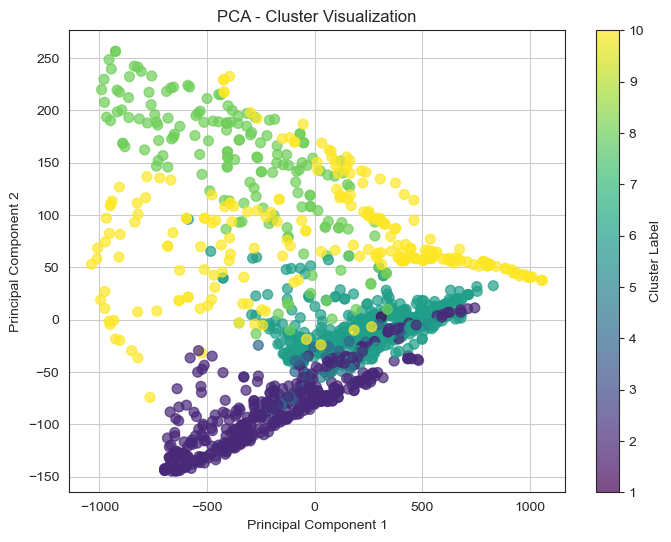

In [24]:
n_obs = 1413
for n_topics, model in spatial_lda_models.items():
    save_cluster_labels_to_csv(model, n_obs, n_topics)

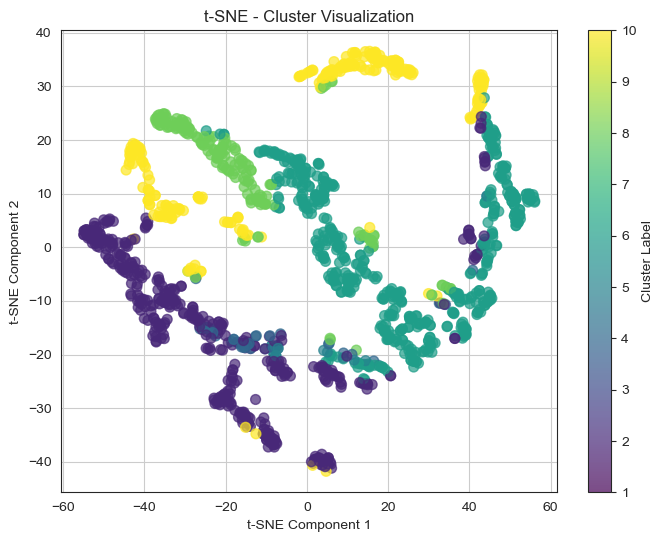

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_clusters_tsne(sample_features, cluster_labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(sample_features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('t-SNE - Cluster Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

topic_weights = model.transform(all_sample_features)
if topic_weights.ndim == 2:
    cluster_labels = topic_weights.argmax(axis=1) + 1 
visualize_clusters_tsne(all_sample_features, cluster_labels)
